In [32]:
import re
import torch
import torch.distributed as dist
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm import tqdm
from IPython.display import display
from torch.nn.parallel import DistributedDataParallelCPU as DDP
from torch.utils.data import DataLoader
from pandas.util import hash_pandas_object
from transformers import DistilBertTokenizerFast, DistilBertModel

from movie_prediction.data_loaders.processed import load_actor_movie_lines
from movie_prediction.constants import *

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext movie_prediction
%reload_ext movie_prediction.constants

In [3]:
sns.set_style('whitegrid')

plt.rcParams['font.size'] = 16

### Configuration

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

ACTOR_LINES_CACHE_FP = '../data/actor_lines.tsv'
PRETRAINED_MODEL = 'distilbert-base-uncased'
BATCH_SIZE = 32

### Load Processed Data

In [5]:
# actor_lines = load_actor_movie_lines(export_fp=ACTOR_LINES_CACHE_FP)
actor_lines = load_actor_movie_lines(cache_fp=ACTOR_LINES_CACHE_FP)
actor_lines.head(2)

Loading actor lines from cache: ../data/actor_lines.tsv


,Line ID,Character,Title,Year,Utterance,Character (Raw),Character (First),Character (Last),Character (First+Last),Character (Full),Principal,Principal Lines
0,56884,JACK,LEGEND,1985,No wait... please... listen...,JACK,JACK,NaN,NaN,JACK,THOMAS CRUISE MAPOTHER IV,1655
1,56885,JACK,LEGEND,1985,Oh no... Don't you understand?,JACK,JACK,NaN,NaN,JACK,THOMAS CRUISE MAPOTHER IV,1655


### Check if Problem Is Tractable 

In [6]:
# Initialize Tokenizer and Models
tokenizer = DistilBertTokenizerFast.from_pretrained(PRETRAINED_MODEL)
model = DistilBertModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [7]:
# Create Dataset
class PrincipalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [ ]:
toy_list = ['THOMAS JEFFREY HANKS', 'PHILIP ANTHONY HOPKINS', 'KURT VOGEL RUSSELL']
toy_data = actor_lines[actor_lines[PRINCIPAL].isin(toy_list)]
toy_dataset = PrincipalDataset(
    tokenizer(list(toy_data[UTTERANCE]), padding=True, truncation=True),
    list(toy_data[PRINCIPAL].replace(
        {'THOMAS JEFFREY HANKS': 0, 'PHILIP ANTHONY HOPKINS': 1, 'KURT VOGEL RUSSELL': 2}))
)
toy_loader = DataLoader(toy_dataset, batch_size=BATCH_SIZE)

def get_embeddings(loader):
    toy_embeddings = []
    with torch.no_grad():
        for batch in tqdm(toy_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            toy_embeddings.append(outputs[0][:, 0])
            
    toy_embeddings = torch.cat(matrices).cpu().detach().numpy()
    
    return toy_embeddings

toy_embeddings = get_embeddings(toy_loader)

 43%|████▎     | 32/75 [04:25<06:00,  8.39s/it]

### Check Actor Distribution

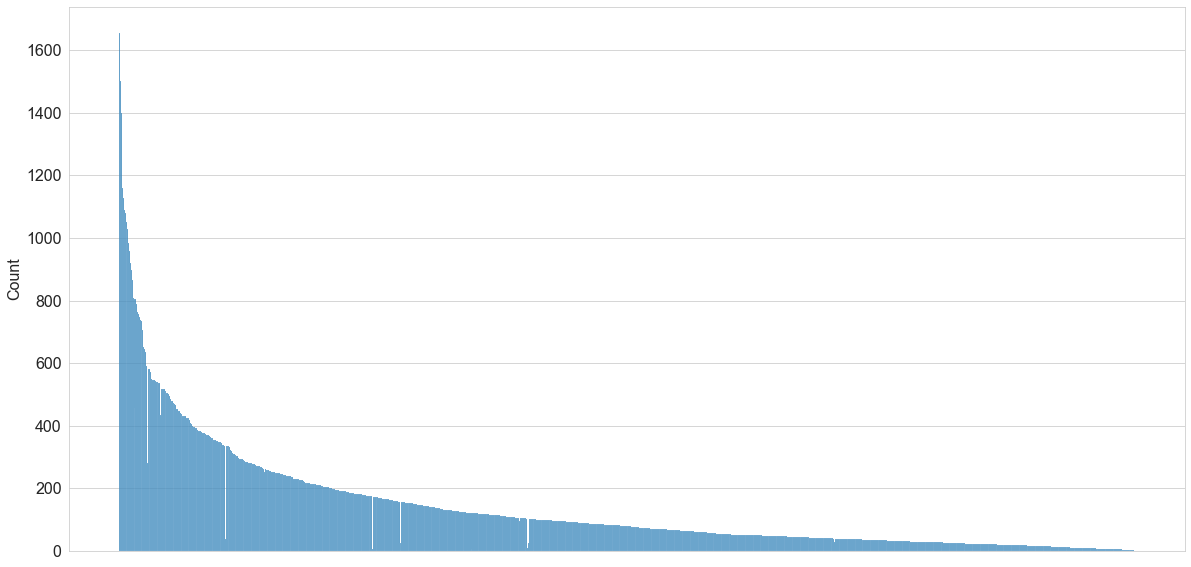

In [17]:
f, ax = plt.subplots(1, 1, figsize=(20,10))
sns.histplot(actor_lines[PRINCIPAL], ax=ax)
ax.xaxis.set_ticklabels([])
ax.get_xaxis().set_visible(False)

In [28]:
# There appears to be a steep drop off after 600
# We will use only actors with more than 600 lines
counts = actor_lines[PRINCIPAL].value_counts()
target_actors = counts[counts > 600].index.values

In [33]:
actor_lines[UTTERANCE_HASH] = hash_pandas_object(actor_lines[UTTERANCE])

target_actor_filt = actor_lines[PRINCIPAL]
actor_

NameError: name 'UTTERANCE_HASH' is not defined

In [ ]:
test_list = ['THOMAS JEFFREY HANKS', 'PHILIP ANTHONY HOPKINS', 'KURT VOGEL RUSSELL']